## Dealer with Memory Model

To great extent we use the theory and code from previous example.

Given simplified scenario of only two dealers $i= \{1,2\}$ with each having a bid and ask prices and the mid-price $p_i(t)$ respectively) given by the average of the two. The differnce between bid and ask prices is termed *spread* and transaction occurs iff $|p_1(t) - p_2(t)| \leq L$.

Under these rules, the market price $P$ of the transaction is the average of mid-prices $\frac{1}{2} (p_1-p_2)|_t$.

The evolution of price for a dealer is given by 1D random walk with binomially distributed displacements:

$$p_i(t + \Delta t) = p_i(t) + c f_i(t), \qquad \qquad i=1,2$$
$$f_i(t) = 
\begin{cases}
    +\Delta p & \mathrm{w.p.} \quad .5 \\
    -\Delta p & \mathrm{w.p.} \quad .5 \\
\end{cases}$$

---
**Dynamics is captured by a random walk with a drift/memory term: **
$$p_i(t + \Delta t) = p_i(t) + \mathbf{d\langle\Delta P\rangle_M \Delta t} + c f_i(t), \qquad i=1,2 $$


The constant $d$ determines whether the dealer is a "trend-follower" ($d>0$) or a "contrarian" ($d < 0$). The added term represents a moving average over the previous price changes:
$$\langle\Delta P\rangle_M = \frac{2}{M (M+1)}\sum_{k=0}^{M-1}(M-k)\Delta P(n-k)$$
$$\Delta P(n) = P(n) - P(n-1) : \textrm{Market price change at the n-th tick}$$


$\langle\Delta P\rangle_M$ is constant during the Random-Walk process, it is only updated at the transaction events. $M$ represents the number of past ticks to average.

---

* The dealer model can be understood as a standard 2D Random walk with absorbing boundaries
* Perform a change in variables, from $p_1(t)$ and $p_2(t)$, to the price difference $D(t)$ and average $A(t)$
$$D(t) = p_1(t) - p_2(t)$$
$$A(t) = \frac{1}{2}\big(p_1(t) + p_2(t)\big)$$

* Dynamics of $D$ and $A$ describe a 2D random walk. The differnce from previous model is subtle and marked in bold.

$$ D(t+\Delta t) = D(t) + 
\begin{cases}
        +2 c \Delta p & \textrm{w.p.} \quad \frac{1}{4} \\
        0 & \textrm{w.p.} \quad \frac{1}{2} \\
        -2 c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
\end{cases}$$
$$A(t+\Delta t) = A(t) + \mathbf{d\langle\Delta P \rangle_M \Delta t} +
\begin{cases}
        +c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
        0 & \textrm{w.p.} \quad \frac{1}{2}\\
        -c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
\end{cases}$$
* When $D(t) = \pm L$ a transaction occurs and the random walk ends, the *particle* is absorbed by the boundary.

We can now simulate the evolution of price avarage and price difference as 2D random walk. Note that the displacements in the *'difference dimension'* are twice as large as the ones in *'average dimension'*.

In [1]:
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import pandas as pd # import pandas library as pd
from datetime import datetime
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)
% matplotlib inline

In [2]:
def logreturn(Pt, tau = 1):
    # Logarithmic retruns of price time series:
    logret = np.log(Pt[tau:]) - np.log(Pt[0:-tau])
    return logret
def normalized(data):
    # Normalize data by std to unit variance
    # <(x - <x>)^2> = 1
    return data/np.sqrt(np.var(data))
def pdf_estimate(data, bins = 50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins = bins, density = True)
    centers  = edges[:-1] + np.diff(edges)/2.0 # get bar centers
    nonzero = hist > 0.0
    return hist[nonzero], centers[nonzero]

Fix issue with yahoo finance API:

In [3]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override() 

In [4]:
# add logarithmic return data to pandas DataFrame data using the 'Adjusted Close' stock price for each day
def computeReturn(data, name, tau):
    data[name]=pd.Series(normalized(logreturn(data['Adj Close'].values, tau)),index=data.index[:-tau])
end_time   = datetime.now()
start_time = datetime(end_time.year - 20, end_time.month, end_time.day)
novartis   = data.get_data_yahoo('NVS',start_time,end_time)  # import toyota stock
computeReturn(novartis, 'Return d1', 1)

[*********************100%***********************]  1 of 1 downloaded


We will make small adjustmets to the functions used previously, corresponding to the changes described n theory:

In [5]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2, 'd': 1.25, 'M':1} # define model parameters
def model2RW(params, p0, deltapm): # deltapm is a constant between transactions
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    ddt = params["d"] * params["dt"] # drift term
    Dt = [price[0] - price[1]]
    At = [np.average(price)]
    # Model1 can be recovered from Model2 by setting deltapm to 0
    while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
        price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
        price = price + ddt*deltapm # constant between transactions
        Dt.append(price[0] - price[1])
        At.append(np.average(price))
    
    return np.array(Dt), np.array(At) - At[0] # center the average around zero

d = -2 : number of steps =  9248 , price change =  -0.00824820006493 d =  -2
d = -1 : number of steps =  9248 , price change =  -0.0054740999668 d =  -1
d = 0 : number of steps =  9248 , price change =  -0.00270000000009 d =  0
d = 1 : number of steps =  9248 , price change =  7.40999666249e-05 d =  1
d = 2 : number of steps =  9248 , price change =  0.00284820006475 d =  2


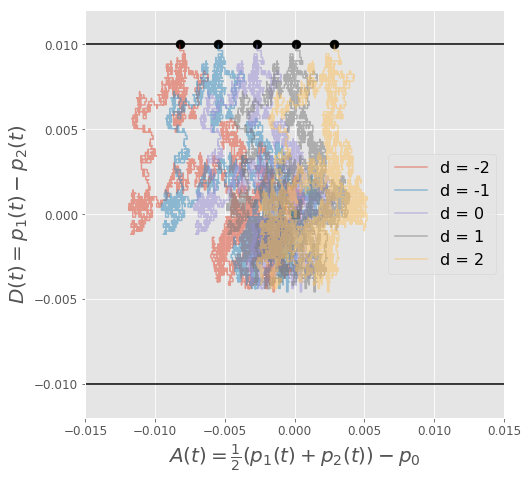

In [20]:
labl = {'xlabel':r'$A(t) = \frac{1}{2}\left(p_1(t) + p_2(t)\right) - p_0$', 'ylabel':r'$D(t) = p_1(t) - p_2(t)$'}
fig, ax = plt.subplots(figsize = (7.5,7.5), subplot_kw = labl)
p0 = [100.25, 100.25] # some starting price
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2, 'd': 1.25, 'M':1} # define model parameters
deltapm = .003
for d in ([-2, -1, 0, 1, 2]):
    np.random.seed(123456)
    params['d'] = d
    Dt, At = model2RW(params, p0, deltapm)
    lbl = "d = {}".format(d)
    ax.plot(At, Dt, alpha = .5, label = lbl)
    ax.scatter(At[0], Dt[0], marker = "s", s = 80, color = "g") # mark starting posiiton
    ax.scatter(At[-1], Dt[-1], marker = "o", s = 80, color = "k") # mark final posiiton -> absorption at boundary
    print(lbl+' : number of steps = ',len(At),', price change = ', At[-1], 'd = ', d)

ax.plot([-0.03,0.03],[params['L'],params['L']],color='k') #top absorbing boundary P=L
ax.plot([-0.03,0.03],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
ax.set_ylim([-0.012, 0.012])
ax.set_xlim([-0.015, 0.015])
ax.legend(loc=5,framealpha=0.8)
plt.show()

Note that if we fix the random seed in each run of the loop, we will obrain exatly the same number of steps before the trade. This is because $D$ is not infulenced by $\langle \Delta P \rangle_M$.

Now we will make longer simulation:

In [7]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2, 'd': 1.25, 'M':1} # define model parameters
np.random.seed(5)

def model2(params, p0, numt):
    def avgprice(dpn): # compute running average
        M = len(dpn)
        weights = np.array(range(1, M+1)) * 2.0 / (M*(M+1))
        return weights.dot(dpn)
    
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    ddt = params["d"] * params["dt"]
    deltapm = 0.0
    
    mktprice = np.zeros(numt)
    ticktime = np.zeros(numt, dtype = np.int)
    dmktprice = np.zeros(numt) # dP(n) needed for running average
    time, tick = 0, 0
    
    while tick < numt:
        while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
            price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
            price = price + deltapm
            time = time + 1
            
        price[:] = np.average(price) # after trade, the new starting posiiton for both is the old mktprice
        mktprice[tick] = price[0] # store the new starting price
        dmktprice[tick] = mktprice[tick] - mktprice[np.max([0, tick -1])] # get delta over one tick
        ticktime[tick] = time
        tick = tick +1
        tick0 = np.max([0, tick - params["M"]]) # compute start tick for the running average
        deltapm = avgprice(dmktprice[tick0:tick]) * ddt # compute update drift term
        
    return ticktime, mktprice

In [41]:
np.random.seed(0)
ticktime2,mktprice2 = model2(params, [100.25, 100.25], 5000)
np.savetxt('model2.txt',np.transpose([ticktime2, mktprice2]))

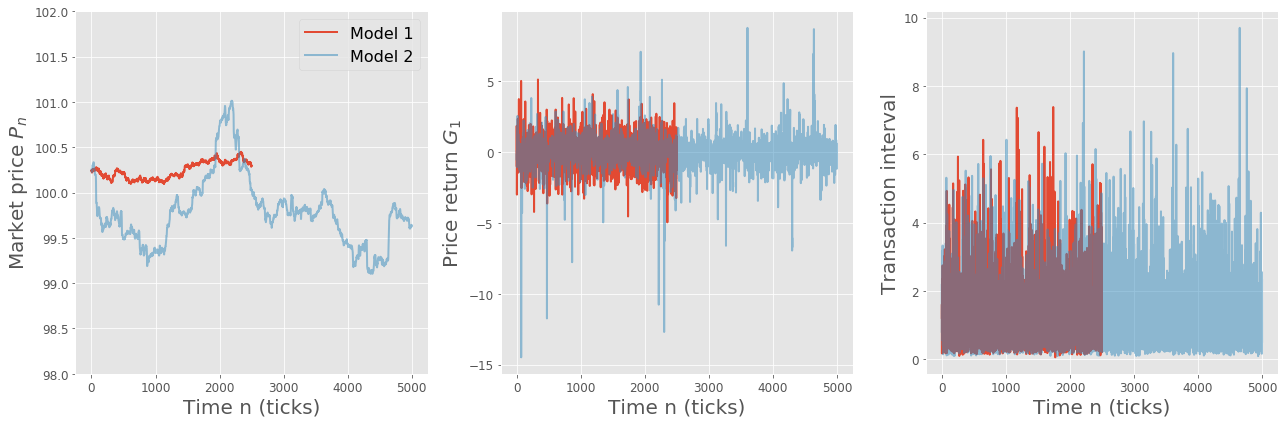

In [10]:
# Load computed data
ticktime, mktprice = np.loadtxt("model1.txt", unpack = True)
ticktime2, mktprice2 = np.loadtxt("model2.txt", unpack = True)

t_interval = normalized((ticktime[1:] - ticktime[0:-1])*params["dt"]) #dt between two trades
dprice = normalized(logreturn(mktprice, tau = 1)) # log return over one tick, normalized to unit variance
t_interval2 = normalized((ticktime2[1:] - ticktime2[0:-1])*params["dt"]) #dt between two trades
dprice2 = normalized(logreturn(mktprice2, tau = 1)) # log return over one tick, normalized to unit variance

fig,[ax,bx,cx]=plt.subplots(figsize=(18,6),ncols=3,subplot_kw={'xlabel':r'Time n (ticks)'})
ax.plot(mktprice, lw = 2, label = "Model 1")
ax.plot(mktprice2, lw = 2, label = "Model 2", alpha = .5)
ax.set_ylim(98,102)
ax.set_ylabel(r'Market price $P_n$')
ax.legend()

bx.plot(dprice, lw = 2)
bx.plot(dprice2, lw= 2, alpha = 0.5)
bx.set_ylabel(r'Price return $G_1$')

cx.plot(t_interval, lw = 2)
cx.plot(t_interval2, lw= 2, alpha = .5)
cx.set_ylabel(r'Transaction interval')
fig.tight_layout() # get nice spacing between plots
plt.show()

We can nicely observe that the trend following behaviour of our model traders allows for higher swings in the price. Returns/Losses of ca 10 standard deviations are realizable in one day.

We next look at the decay plot:

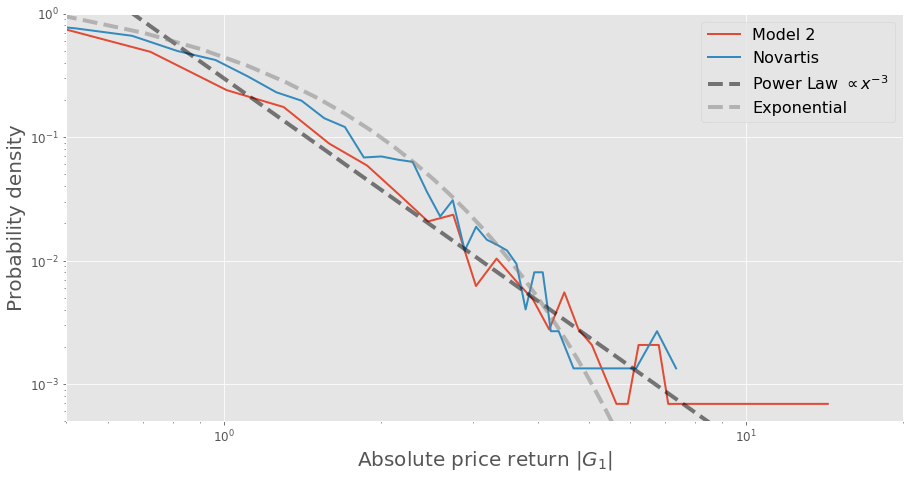

In [16]:
fig,ax, = plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Absolute price return $|G_1|$', 'ylabel':r'Probability density'})

for data, lbl in zip ([dprice2, novartis["Return d1"]], ["Model 2", "Novartis"]):
    edges,hist = pdf_estimate(np.abs(data),bins = 50) # probability density of price change G_1 between ticks
    ax.plot(hist, edges,  lw=2, label=lbl)

x = np.linspace(0.1, 10)
ax.plot(x,.3*x**(-3), lw=4, ls='--', color='k', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
ax.plot(x, 2*np.exp(-1.5*x), lw=4, color='gray', ls='--', alpha=0.5, label=r'Exponential')

ax.set_xlim(5e-1, 2e1)
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.semilogx()
ax.legend()
plt.show()

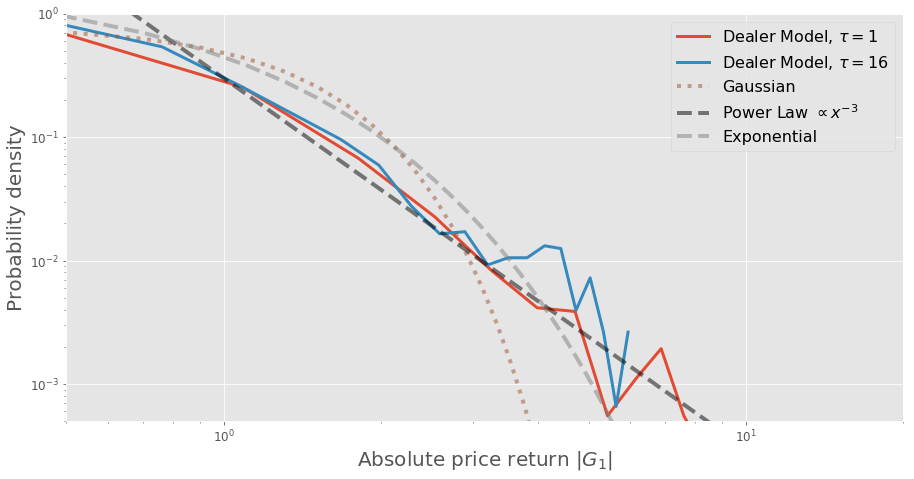

In [25]:
fig,ax = plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Absolute price return $|G_1|$', 'ylabel':r'Probability density'})

ticktime1, mktprice1 = np.loadtxt("model2.txt", unpack = True)
t_interval1 = normalized((ticktime1[1:] - ticktime1[0:-1])*params["dt"]) #dt between two trades
dprice1 = normalized(logreturn(mktprice1, tau = 1)) # log return over one tick, normalized to unit variance

edges,hist = pdf_estimate(np.abs(dprice1),bins=20) # probability density of price change G_1 between ticks
ax.plot(hist, edges,  lw=3, label=r'Dealer Model, $\tau = 1$')

ticktime16, mktprice16 = np.loadtxt("model2.txt", unpack = True)
t_interval16 = normalized((ticktime16[1:] - ticktime16[0:-1])*params["dt"]) #dt between two trades
dprice16 = normalized(logreturn(mktprice16, tau = 16)) # log return over one tick, normalized to unit variance

edges,hist = pdf_estimate(np.abs(dprice16),bins=20) # probability density of price change G_1 between ticks
ax.plot(hist, edges,  lw=3, label=r'Dealer Model, $\tau = 16$')

x = np.linspace(0.1, 10)
ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=4,ls=':',color='sienna',alpha=0.5,label=r'Gaussian')
ax.plot(x,.3*x**(-3), lw=4, ls='--', color='k', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
ax.plot(x, 2*np.exp(-1.5*x), lw=4, color='gray', ls='--', alpha=0.5, label=r'Exponential')

ax.set_xlim(5e-1, 2e1)
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.semilogx()
ax.legend()
plt.show()

Now we will model case when we let traders acquire all kinds of behaviour: trend-following, contrarians and indifferent, to see how this infulences the evolution of the price.

In [17]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2, 'd': 1.0, 'M': 10} # define model parameters
np.random.seed(0)

def model2(params, p0, numt):
    def avgprice(dpn): # compute running average
        M = len(dpn)
        weights = np.array(range(1, M+1)) * 2.0 / (M*(M+1))
        return weights.dot(dpn)
    def dtime(i, dpm):
        if i <= 1000: return -params['d'] # contrarians
        elif i <= 2000: return 0.0 # indifferent, memoryless
        elif i <= 3000: return params['d'] # trend followers
        elif dpm >= 0.0: return params['d'] # 3000-4000 trend-followers if running average increasing
        else: return -params['d'] # 3000-4000 contrarians if running average increasing
    
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    deltapm = 0.0
    
    mktprice = np.zeros(numt)
    ticktime = np.zeros(numt, dtype = np.int)
    dmktprice = np.zeros(numt) # dP(n) needed for running average
    time, tick = 0, 0
    
    while tick < numt:
        ddt = dtime(tick, deltapm) * params["dt"]
        while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
            price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
            price = price + deltapm
            time = time + 1
            
        price[:] = np.average(price) # after trade, the new starting posiiton for both is the old mktprice
        mktprice[tick] = price[0] # store the new starting price
        dmktprice[tick] = mktprice[tick] - mktprice[np.max([0, tick -1])] # get delta over one tick
        ticktime[tick] = time
        tick = tick +1
        tick0 = np.max([0, tick - params["M"]]) # compute start tick for the running average
        deltapm = avgprice(dmktprice[tick0:tick]) * ddt # compute update drift term
        
    return ticktime, mktprice

In [ ]:
# Not run --- instead we import precomputed data
np.random.seed(0)
ticktime2t,mktprice2t = model2t(params, [100.25, 100.25], 4001)
np.savetxt('model2t.txt',np.transpose([ticktime2t, mktprice2t]))

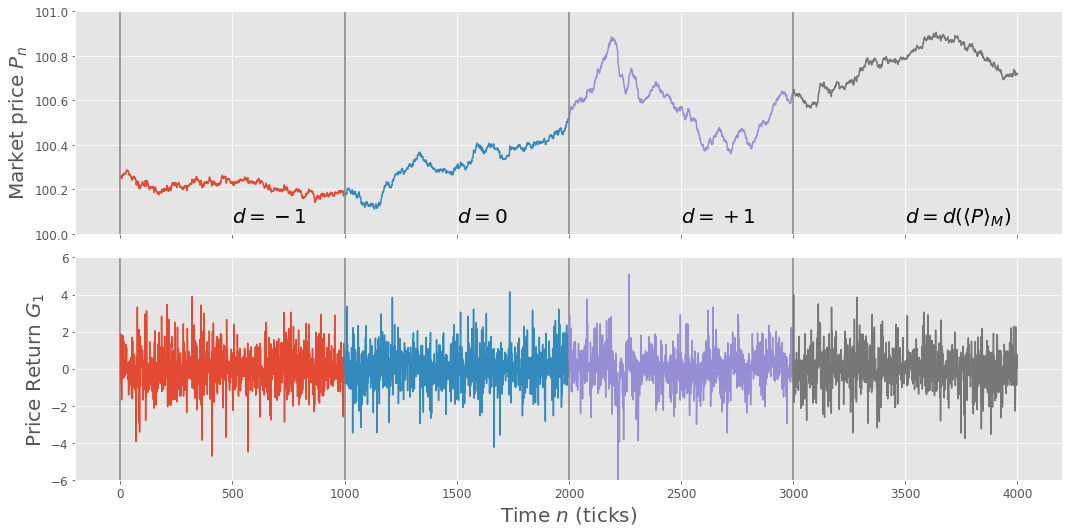

In [18]:
ticktime2t, mktprice2t = np.loadtxt('model2t.txt',unpack=True) # read saved data from file
fig,[ax,bx] = plt.subplots(figsize=(15,7.5), nrows=2, sharex=True)

for i,lbl in zip(range(4), [r'$d=-1$', r'$d=0$', r'$d=+1$', r'$d=d(\left\langle P\right\rangle_M)$']):
    n0, n1 = i*1000, (i+1)*1000
    dprice = normalized(logreturn(mktprice2t[n0:n1],1))
    ax.plot(range(n0,n1), mktprice2t[n0:n1])
    ax.plot([n0,n0],[100,102], color='gray')
    ax.text(n0+500, 100.05, lbl, fontsize=20)
    bx.plot([n0,n0],[-6,6],color='gray')
    bx.plot(range(n0+1,n1), dprice)

ax.set_ylim(100,101)
bx.set_ylim(-6,6)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price Return $G_1$')
bx.set_xlabel(r'Time $n$ (ticks)')
fig.tight_layout()
plt.show()

We observe that the price return evolution is the most unstable if the dealers are trend followers. If the dealers react according to the running average from preceding `M` 'days', the result is almost linear increase of returns.